<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Projects/Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Air Quality**

## Introduction
This notebook builds and validates a high-accuracy **XGBoost** model to forecast Benzene air pollution using the UCI Air Quality dataset.

The model achieved outstanding predictive performance,
 * **R-squared of 1.000**
 * **Mean Absolute Error of 0.05**
 * **Root Mean Squared Error of 0.12**

 Feature importance analysis identified other sensor readings as the most significant predictors.

### Dataset:
https://archive.ics.uci.edu/dataset/360/air+quality

## IMPORT LIBRARIES

In [ ]:
# !pip install -q xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")


Libraries imported successfully.


## DATA LOADING AND PREPARATION

In [ ]:
try:
    df = pd.read_csv(
        '/content/drive/MyDrive/Air Quality/AirQualityUCI.csv',
        sep=';',
        decimal=','
    )
    print("Dataset loaded successfully. Initial shape:", df.shape)
except FileNotFoundError:
    print("Error: 'AirQualityUCI.csv' not found. Please upload the file.")
    exit()


Dataset loaded successfully. Initial shape: (9471, 17)


### Data Cleaning and Datetime Index Creation

In [ ]:
# The dataset uses -200 for missing values. We replace this with NumPy's NaN.
df.replace(to_replace=-200, value=np.nan, inplace=True)

# drop the last two empty columns
df.dropna(axis=1, how='all', inplace=True)

# more robust method than parsing dates during the read operation
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.set_index('datetime')
df = df.drop(columns=['Date', 'Time']) # Drop original date/time columns

# standard method: use forward-fill to impute missing values
# for time-series data, as it assumes the value remains constant from the last known point.
df.ffill(inplace=True)

print("\nData cleaned, datetime index created. Final shape:", df.shape)
print("\nData Head:")
print(df.head())


Data cleaned, datetime index created. Final shape: (9471, 13)

Data Head:
                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
datetime                                                            
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172

## EXPLORATORY DATA ANALYSIS (EDA)

### Time-Series with Anomaly Highlighting

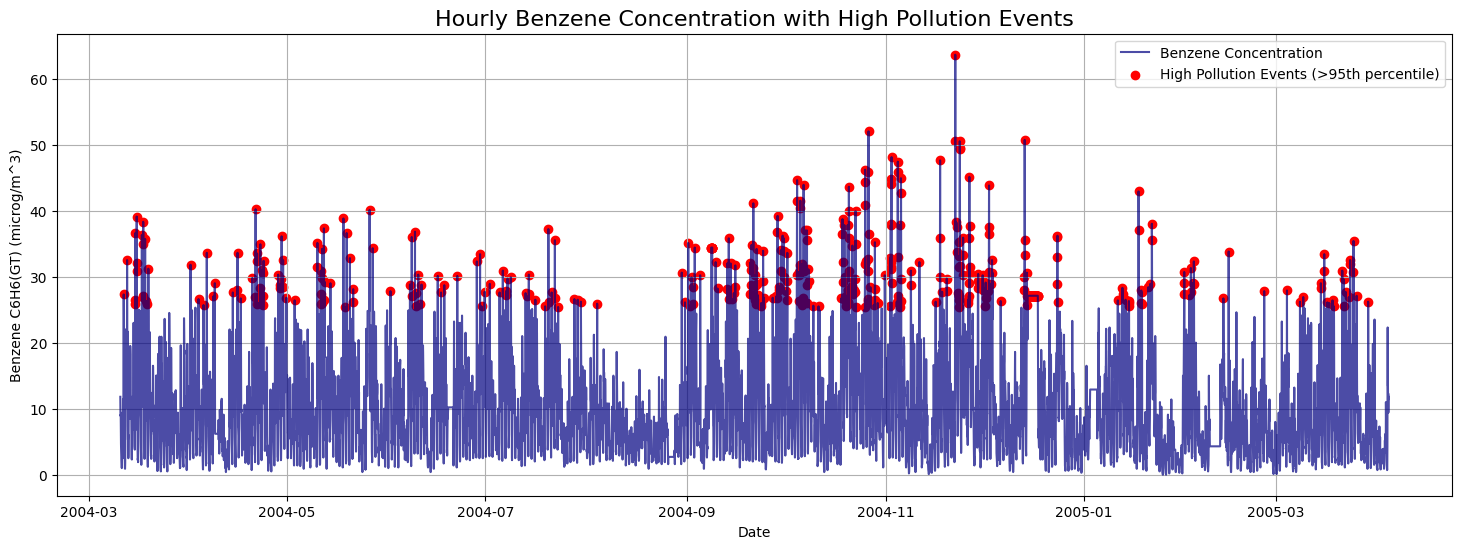

In [ ]:
# plot our target variable-Benzene concentration (C6H6(GT)) over time
# then calculate a threshold for high pollution (95th percentile) - red Dots
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['C6H6(GT)'], label='Benzene Concentration', color='navy', alpha=0.7)

# Highlight anomalies
high_pollution_threshold = df['C6H6(GT)'].quantile(0.95)
anomalies = df[df['C6H6(GT)'] > high_pollution_threshold]
plt.scatter(anomalies.index, anomalies['C6H6(GT)'], color='red', label='High Pollution Events (>95th percentile)')

plt.title('Hourly Benzene Concentration with High Pollution Events', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Benzene C6H6(GT) (microg/m^3)')
plt.legend()
plt.grid(True)
plt.show()


### Seasonal-Weekly Heatmap

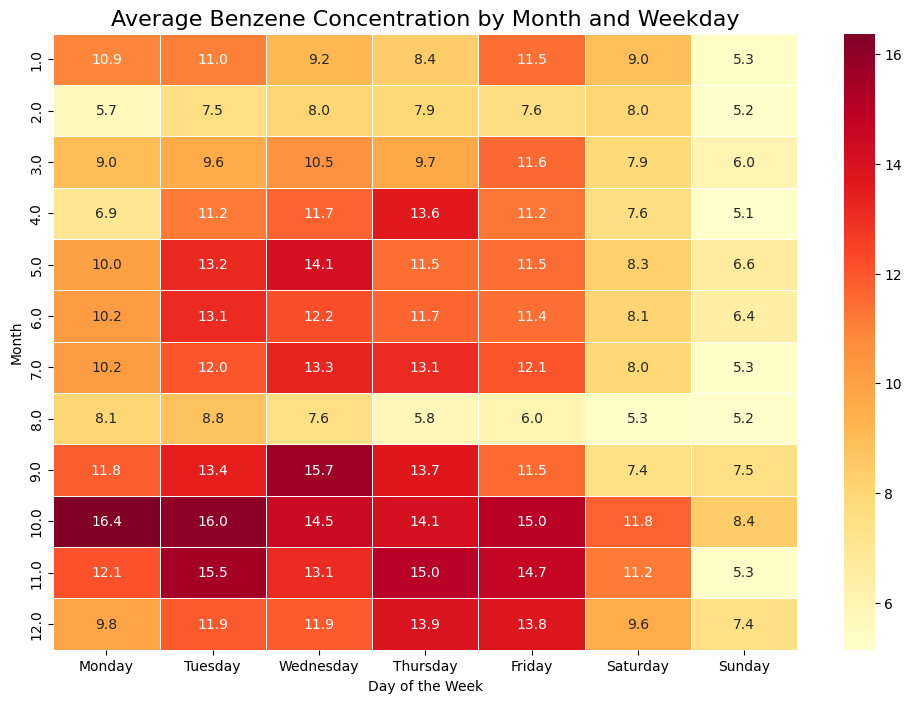

In [ ]:
# weekly and monthly patterns in pollution
# average Benzene concentration for each combination
df_eda = df.copy()
df_eda['month'] = df_eda.index.month
df_eda['weekday'] = df_eda.index.day_name()
heatmap_data = pd.pivot_table(df_eda, values='C6H6(GT)', index='month', columns='weekday', aggfunc='mean')
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[weekday_order]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".1f", linewidths=.5)
plt.title('Average Benzene Concentration by Month and Weekday', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.show()


## FEATURE ENGINEERING

In [ ]:
# capture cyclical patterns
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Define Target and Features
TARGET = 'C6H6(GT)'
ground_truth_cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
features = [col for col in df.columns if col not in ground_truth_cols]

X = df[features]
y = df[TARGET]

# Chronological Train-Test Split
# train on 2004 - test on 2005
split_date = '2005-01-01'
X_train, X_test = X.loc[X.index < split_date], X.loc[X.index >= split_date]
y_train, y_test = y.loc[y.index < split_date], y.loc[y.index >= split_date]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (7110, 11)
Test data shape: (2247, 11)


## Train the XGBoost Model

In [ ]:
# XGBoost Regressor
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01, #influence of new tree's prediction
    objective='reg:squarederror', # minimizes the squared error
    early_stopping_rounds=50, # prevent overfitting
    random_state=42
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)
print("Model training completed.")


Model training completed.


## MODEL EVALUATION AND VISUALIZATION

### Make Predictions and Evaluate

In [ ]:
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Model Evaluation on 2005 Test Data ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



--- Model Evaluation on 2005 Test Data ---
R-squared (R²): 1.000
Mean Absolute Error (MAE): 0.05
Root Mean Squared Error (RMSE): 0.12


### Actual vs. Predicted Plot

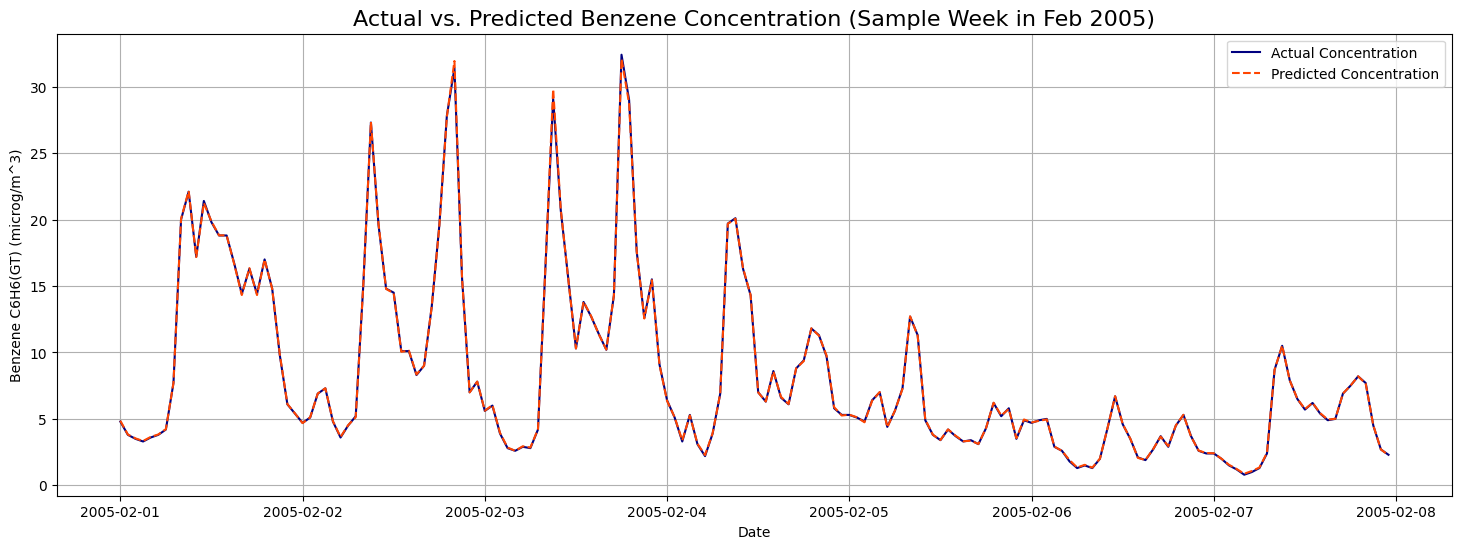

In [ ]:
# plot actual and predicted values
plt.figure(figsize=(18, 6))
test_data_with_preds = y_test.to_frame(name='Actual')
test_data_with_preds['Predicted'] = y_pred

sample_period = (test_data_with_preds.index >= '2005-02-01') & (test_data_with_preds.index < '2005-02-08')
sample_data = test_data_with_preds[sample_period]

plt.plot(sample_data.index, sample_data['Actual'], label='Actual Concentration', color='navy')
plt.plot(sample_data.index, sample_data['Predicted'], label='Predicted Concentration', color='orangered', linestyle='--')
plt.title('Actual vs. Predicted Benzene Concentration (Sample Week in Feb 2005)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Benzene C6H6(GT) (microg/m^3)')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance Plot

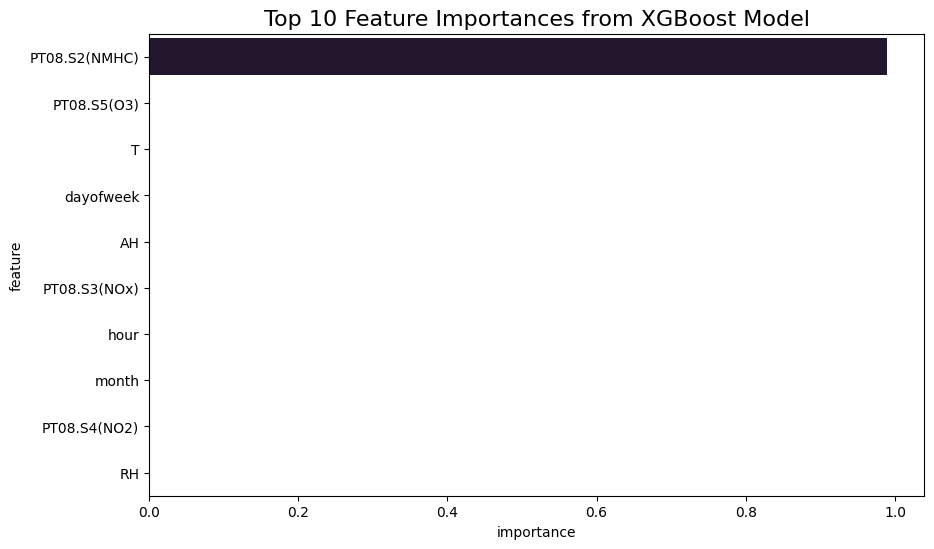

In [ ]:
# which features the trained model found most important
feature_importance = pd.DataFrame({'feature': features, 'importance': reg.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='rocket')
plt.title('Top 10 Feature Importances from XGBoost Model', fontsize=16)
plt.show()